In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv('dl0qiiqg8ytvdnss.csv')

# Convert dates
df['datadate'] = pd.to_datetime(df['datadate'])

# Handle missing values
df = df.fillna({
    'xrd': 0,  # Most retailers report minimal R&D
})
# Handle employee data separately (can't use transform with non-numeric data)
emp_means = df.groupby('gvkey')['emp'].mean()
df['emp'] = df.apply(lambda row: emp_means[row['gvkey']] if pd.isna(row['emp']) else row['emp'], axis=1)

# Create metrics
df['sga_ratio'] = df['xsga'] / df['revt']
df['rd_ratio'] = df['xrd'] / df['revt']
df['revenue_per_employee'] = df['revt'] / df['emp']
df['ebitda_margin'] = df['oibdp'] / df['revt']
df['current_ratio'] = df['act'] / df['lct']
df['inventory_turnover'] = df['revt'] / df['invt']

# Days in inventory and receivables (for CCC)
df['days_inventory'] = 365 * df['invt'] / df['revt']
df['days_receivables'] = 365 * df['rect'] / df['revt']

# Replace infinities with NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define time periods
numeric_cols = ['fyear', 'sga_ratio', 'rd_ratio', 'revenue_per_employee',
                'ebitda_margin', 'current_ratio', 'inventory_turnover',
                'days_inventory', 'days_receivables']

baseline = df[(df['fyear'] >= 2014) & (df['fyear'] <= 2016)]
early_adoption = df[(df['fyear'] >= 2017) & (df['fyear'] <= 2019)]
performance = df[(df['fyear'] >= 2020) & (df['fyear'] <= 2024)]

# Calculate company-level averages for numeric columns
baseline_avg = baseline.groupby('gvkey')[numeric_cols].mean()
early_avg = early_adoption.groupby('gvkey')[numeric_cols].mean()
performance_avg = performance.groupby('gvkey')[numeric_cols].mean()

# Get company info
company_info = df[['gvkey', 'tic', 'conm', 'sic']].drop_duplicates().set_index('gvkey')

# Find common companies (as a list, not a set)
common_companies = list(set(baseline_avg.index) & set(performance_avg.index))
print(f"Number of companies with data across all periods: {len(common_companies)}")

# Filter for common companies
baseline_filtered = baseline_avg.loc[common_companies]
performance_filtered = performance_avg.loc[common_companies]

# Create merged dataframe with performance metrics
merged_df = pd.DataFrame(index=common_companies)
merged_df['sga_ratio_baseline'] = baseline_filtered['sga_ratio']
merged_df['sga_ratio_recent'] = performance_filtered['sga_ratio']
merged_df['ebitda_margin_baseline'] = baseline_filtered['ebitda_margin']
merged_df['ebitda_margin_recent'] = performance_filtered['ebitda_margin']
merged_df['revenue_per_employee'] = performance_filtered['revenue_per_employee']

# Calculate improvements
merged_df['sga_reduction'] = merged_df['sga_ratio_baseline'] - merged_df['sga_ratio_recent']
merged_df['ebitda_improvement'] = merged_df['ebitda_margin_recent'] - merged_df['ebitda_margin_baseline']

# Fill NaN values with median
for col in merged_df.columns:
    if merged_df[col].isna().any():
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Classify companies
def classify_company(row):
    if row['sga_reduction'] > 0.01 and row['ebitda_improvement'] > 0.02:
        return 'AI Leader'
    elif row['sga_reduction'] < 0 and row['ebitda_improvement'] < 0:
        return 'AI Laggard'
    else:
        return 'Turnaround Opportunity'

merged_df['classification'] = merged_df.apply(classify_company, axis=1)
print(merged_df['classification'].value_counts())

# Add company names and tickers
merged_df = merged_df.join(company_info[['tic', 'conm', 'sic']])

# Model preparation
features = ['sga_ratio_baseline', 'ebitda_margin_baseline', 'revenue_per_employee']
X = merged_df[features]

# Convert classification to numeric format
le = LabelEncoder()
y = le.fit_transform(merged_df['classification'])

# Train model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X, y)

# Output results
print("\nFeature importance for each classification:")
for i, category in enumerate(le.classes_):
    print(f"\n{category}:")
    for j, feature in enumerate(X.columns):
        print(f"{feature}: {model.coef_[i, j]:.4f}")

# Display examples of each class
print("\nExamples of companies in each category:")
for category in merged_df['classification'].unique():
    examples = merged_df[merged_df['classification'] == category].head(3)
    print(f"\n{category} examples:")
    for idx, row in examples.iterrows():
        print(f"{row['conm']} ({row['tic']}): SG&A Change: {row['sga_reduction']:.4f}, EBITDA Change: {row['ebitda_improvement']:.4f}")

Number of companies with data across all periods: 101
classification
AI Laggard                53
Turnaround Opportunity    39
AI Leader                  9
Name: count, dtype: int64

Feature importance for each classification:

AI Laggard:
sga_ratio_baseline: -0.1399
ebitda_margin_baseline: 0.7766
revenue_per_employee: 0.0009

AI Leader:
sga_ratio_baseline: 0.8331
ebitda_margin_baseline: -0.6997
revenue_per_employee: 0.0007

Turnaround Opportunity:
sga_ratio_baseline: -0.6932
ebitda_margin_baseline: -0.0769
revenue_per_employee: -0.0016

Examples of companies in each category:

AI Laggard examples:
MACY'S INC (M): SG&A Change: -0.0774, EBITDA Change: -0.0459
SPOT COFFEE LTD (SCFFF): SG&A Change: -0.0397, EBITDA Change: -0.0418
SPROUTS FARMERS MARKET (SFM): SG&A Change: -0.0595, EBITDA Change: -0.0044

Turnaround Opportunity examples:
OLLIE'S BARGAIN OUTLET HLDGS (OLLI): SG&A Change: 0.0218, EBITDA Change: 0.0084
GOOD TIMES RESTAURANTS INC (GTIM): SG&A Change: 0.0294, EBITDA Change: 0.0

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [18]:
# Create company selection table
selection_table = merged_df.groupby('classification').agg({
    'tic': 'count',
    'sga_ratio_baseline': 'mean',
    'ebitda_margin_baseline': 'mean',
    'sga_reduction': 'mean',
    'ebitda_improvement': 'mean'
}).rename(columns={'tic': 'Count'})

# Display with formatted percentages
print("Company Classification Summary:")
display(selection_table.style.format({
    'sga_ratio_baseline': '{:.2f}',
    'ebitda_margin_baseline': '{:.2f}',
    'sga_reduction': '{:.3f}',
    'ebitda_improvement': '{:.3f}'
}))

Company Classification Summary:


,Count,sga_ratio_baseline,ebitda_margin_baseline,sga_reduction,ebitda_improvement
classification,,,,,
AI Laggard,53,0.19,0.18,-0.045,-0.070
AI Leader,9,0.35,0.00,0.090,0.100
Turnaround Opportunity,39,0.17,0.13,0.006,0.005


In [19]:
# Create descriptive statistics table
desc_stats = merged_df[['sga_ratio_baseline', 'sga_ratio_recent',
                         'ebitda_margin_baseline', 'ebitda_margin_recent',
                         'revenue_per_employee', 'sga_reduction',
                         'ebitda_improvement']].describe()

print("Descriptive Statistics of Key Metrics:")
display(desc_stats.style.format('{:.3f}'))

Descriptive Statistics of Key Metrics:


,sga_ratio_baseline,sga_ratio_recent,ebitda_margin_baseline,ebitda_margin_recent,revenue_per_employee,sga_reduction,ebitda_improvement
count,101.000,101.000,101.000,101.000,101.000,101.000,101.000
mean,0.199,0.219,0.142,0.115,219.129,-0.014,-0.026
std,0.149,0.151,0.200,0.183,393.677,0.075,0.108
min,0.018,0.022,-0.752,-0.239,24.686,-0.354,-0.632
25%,0.105,0.114,0.066,0.049,72.309,-0.021,-0.047
50%,0.169,0.193,0.103,0.082,140.617,-0.004,-0.013
75%,0.232,0.255,0.145,0.126,235.584,0.007,0.012
max,1.019,0.819,0.982,0.982,3783.496,0.376,0.525


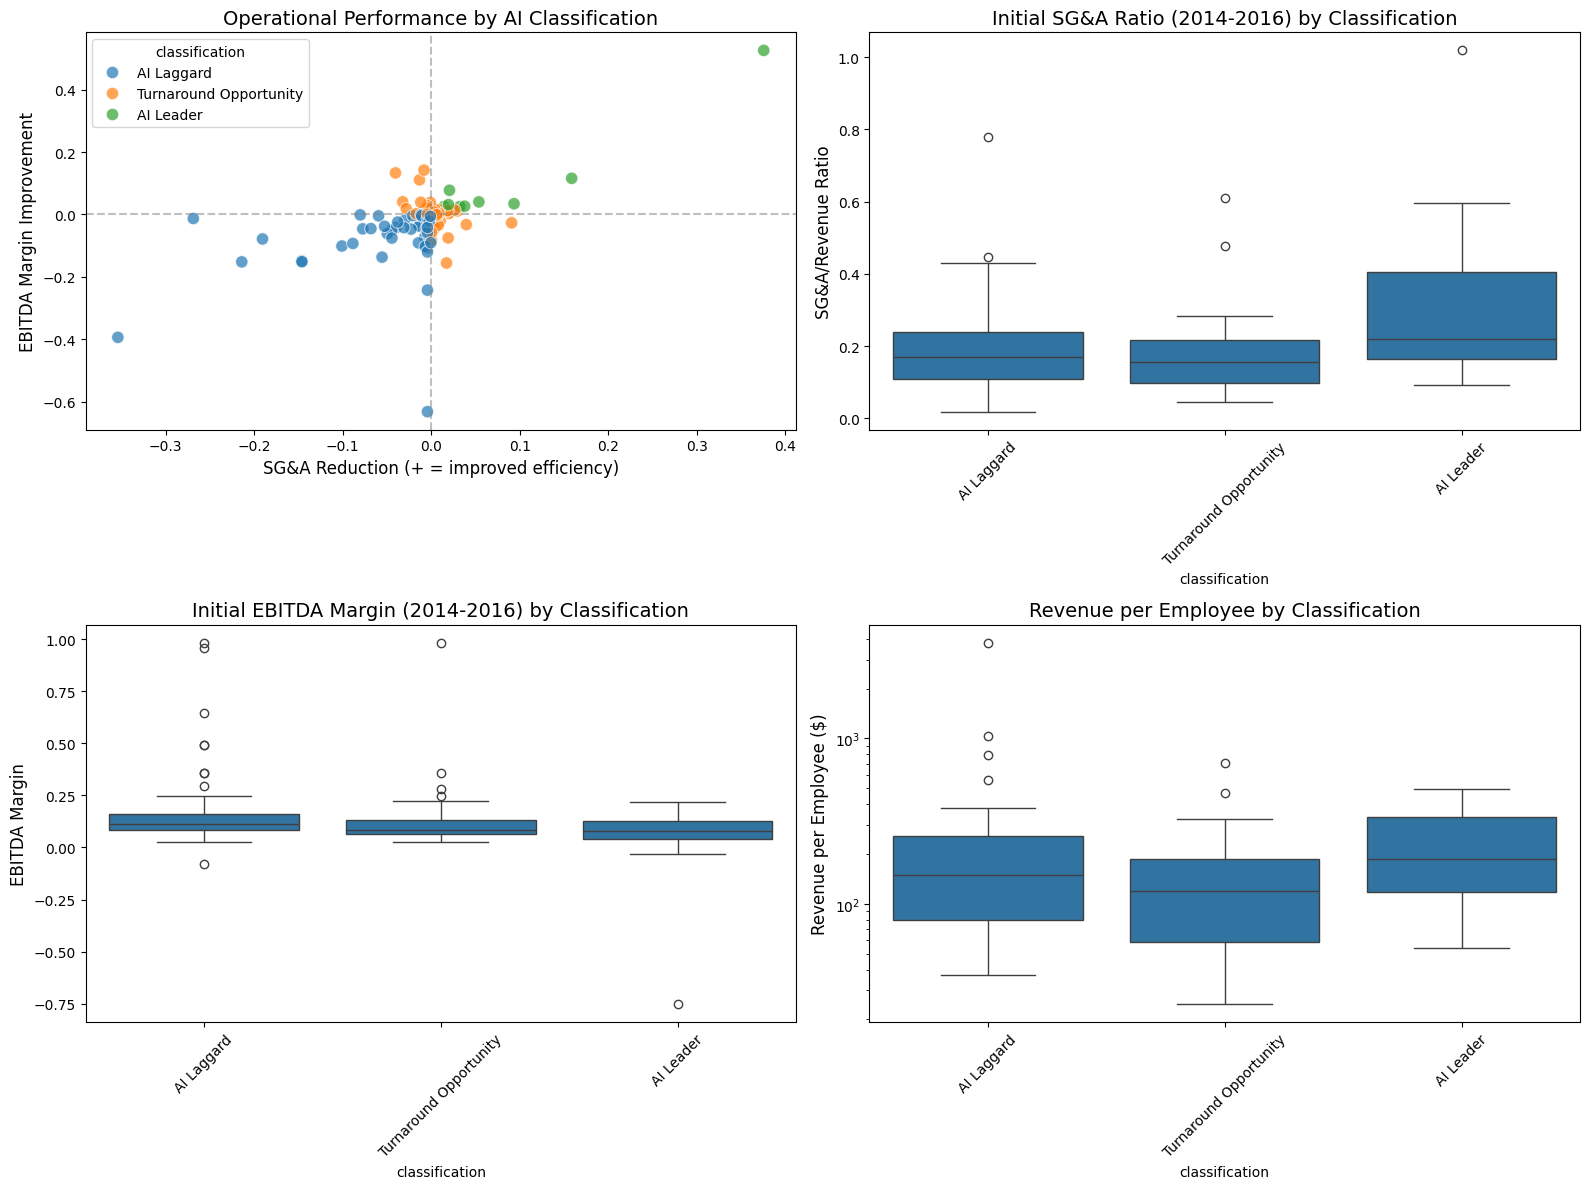

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: SG&A reduction vs EBITDA improvement
sns.scatterplot(ax=axes[0,0], data=merged_df, x='sga_reduction', y='ebitda_improvement',
                hue='classification', s=80, alpha=0.7)
axes[0,0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0,0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0,0].set_title('Operational Performance by AI Classification', fontsize=14)
axes[0,0].set_xlabel('SG&A Reduction (+ = improved efficiency)', fontsize=12)
axes[0,0].set_ylabel('EBITDA Margin Improvement', fontsize=12)

# 2. Boxplot: Initial SG&A ratio
sns.boxplot(ax=axes[0,1], data=merged_df, x='classification', y='sga_ratio_baseline')
axes[0,1].set_title('Initial SG&A Ratio (2014-2016) by Classification', fontsize=14)
axes[0,1].set_ylabel('SG&A/Revenue Ratio', fontsize=12)
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Boxplot: Initial EBITDA margin
sns.boxplot(ax=axes[1,0], data=merged_df, x='classification', y='ebitda_margin_baseline')
axes[1,0].set_title('Initial EBITDA Margin (2014-2016) by Classification', fontsize=14)
axes[1,0].set_ylabel('EBITDA Margin', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Revenue per employee comparison
sns.boxplot(ax=axes[1,1], data=merged_df, x='classification', y='revenue_per_employee')
axes[1,1].set_title('Revenue per Employee by Classification', fontsize=14)
axes[1,1].set_ylabel('Revenue per Employee ($)', fontsize=12)
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('ai_readiness_classification.png', dpi=300)
plt.show()

In [36]:
# Conduct sensitivity analysis with alternative classification thresholds
def classify_alt(row, sga_threshold, ebitda_threshold):
    if row['sga_reduction'] > sga_threshold and row['ebitda_improvement'] > ebitda_threshold:
        return 'AI Leader'
    elif row['sga_reduction'] < -sga_threshold and row['ebitda_improvement'] < -ebitda_threshold:
        return 'AI Laggard'
    else:
        return 'Turnaround Opportunity'

# Test different thresholds
thresholds = [(0.005, 0.01), (0.01, 0.02), (0.02, 0.03)]
results = []

for sga_t, ebitda_t in thresholds:
    merged_df[f'class_{sga_t}_{ebitda_t}'] = merged_df.apply(
        lambda row: classify_alt(row, sga_t, ebitda_t), axis=1)
    counts = merged_df[f'class_{sga_t}_{ebitda_t}'].value_counts()
    results.append([sga_t, ebitda_t, counts['AI Leader'],
                   counts['Turnaround Opportunity'], counts['AI Laggard']])

# Create sensitivity table
sensitivity_df = pd.DataFrame(results,
                             columns=['SG&A Threshold', 'EBITDA Threshold',
                                      'AI Leaders', 'Turnaround', 'AI Laggards'])
print("Classification Sensitivity Analysis:")
display(sensitivity_df)

Classification Sensitivity Analysis:


,SG&A Threshold,EBITDA Threshold,AI Leaders,Turnaround,AI Laggards
0,0.005,0.01,15,60,26
1,0.010,0.02,9,71,21
2,0.020,0.03,5,79,17


In [25]:
# Fix for the 'at' KeyError - we need to use the original DataFrame, not filtered averages
# First, let's check what columns we have available
print("Available columns in 'baseline':", baseline.columns.tolist())

# Now use the correct approach to create control variables
# Get company average total assets and liabilities from baseline period
company_assets = baseline.groupby('gvkey')['at'].mean()
company_liabilities = baseline.groupby('gvkey')['lct'].mean()

# Add these to merged_df
merged_df['company_size'] = np.log(company_assets.loc[merged_df.index])
merged_df['leverage'] = company_liabilities.loc[merged_df.index] / company_assets.loc[merged_df.index]

# Now create correlation matrix with these new columns
corr_metrics = merged_df[['sga_ratio_baseline', 'ebitda_margin_baseline',
                         'revenue_per_employee', 'company_size', 'leverage',
                         'sga_reduction', 'ebitda_improvement']]

# Continue with the rest of the code as before

Available columns in 'baseline': ['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic', 'conm', 'curcd', 'act', 'at', 'capx', 'emp', 'invt', 'lct', 'ni', 'oibdp', 'rect', 'revt', 'xrd', 'xsga', 'costat', 'sic', 'sga_ratio', 'rd_ratio', 'revenue_per_employee', 'ebitda_margin', 'current_ratio', 'inventory_turnover', 'days_inventory', 'days_receivables']


In [26]:
# Check merged_df index structure
print("merged_df index type:", type(merged_df.index))
print("First few indices:", list(merged_df.index)[:5])

# Create control variables directly - safer approach
asset_dict = {}
leverage_dict = {}

# Calculate average assets and liabilities for each company
for gvkey in merged_df.index:
    if gvkey in baseline['gvkey'].values:
        company_data = baseline[baseline['gvkey'] == gvkey]
        avg_assets = company_data['at'].mean()
        avg_liabilities = company_data['lct'].mean()

        # Avoid division by zero or log of zero/negative
        if avg_assets > 0:
            asset_dict[gvkey] = np.log(avg_assets)
            leverage_dict[gvkey] = avg_liabilities / avg_assets if avg_assets > 0 else 0
        else:
            asset_dict[gvkey] = 0
            leverage_dict[gvkey] = 0

# Add to merged_df as new columns
merged_df['company_size'] = merged_df.index.map(lambda x: asset_dict.get(x, 0))
merged_df['leverage'] = merged_df.index.map(lambda x: leverage_dict.get(x, 0))

# Now create correlation matrix with verified columns
print("Columns in merged_df:", merged_df.columns.tolist())
corr_metrics = merged_df[['sga_ratio_baseline', 'ebitda_margin_baseline',
                         'revenue_per_employee', 'company_size', 'leverage',
                         'sga_reduction', 'ebitda_improvement']]

merged_df index type: <class 'pandas.core.indexes.base.Index'>
First few indices: [4611, 183307, 24076, 17934, 22543]
Columns in merged_df: ['sga_ratio_baseline', 'sga_ratio_recent', 'ebitda_margin_baseline', 'ebitda_margin_recent', 'revenue_per_employee', 'sga_reduction', 'ebitda_improvement', 'classification', 'tic', 'conm', 'sic', 'class_0.005_0.01', 'class_0.01_0.02', 'class_0.02_0.03', 'company_size', 'leverage']


Optimization terminated successfully.
         Current function value: 0.820604
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:         classification   No. Observations:                  101
Model:                        MNLogit   Df Residuals:                       89
Method:                           MLE   Df Model:                           10
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                  0.1093
Time:                        12:39:15   Log-Likelihood:                -82.881
converged:                       True   LL-Null:                       -93.048
Covariance Type:            nonrobust   LLR p-value:                   0.02625
             classification=AI Leader       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.5199      

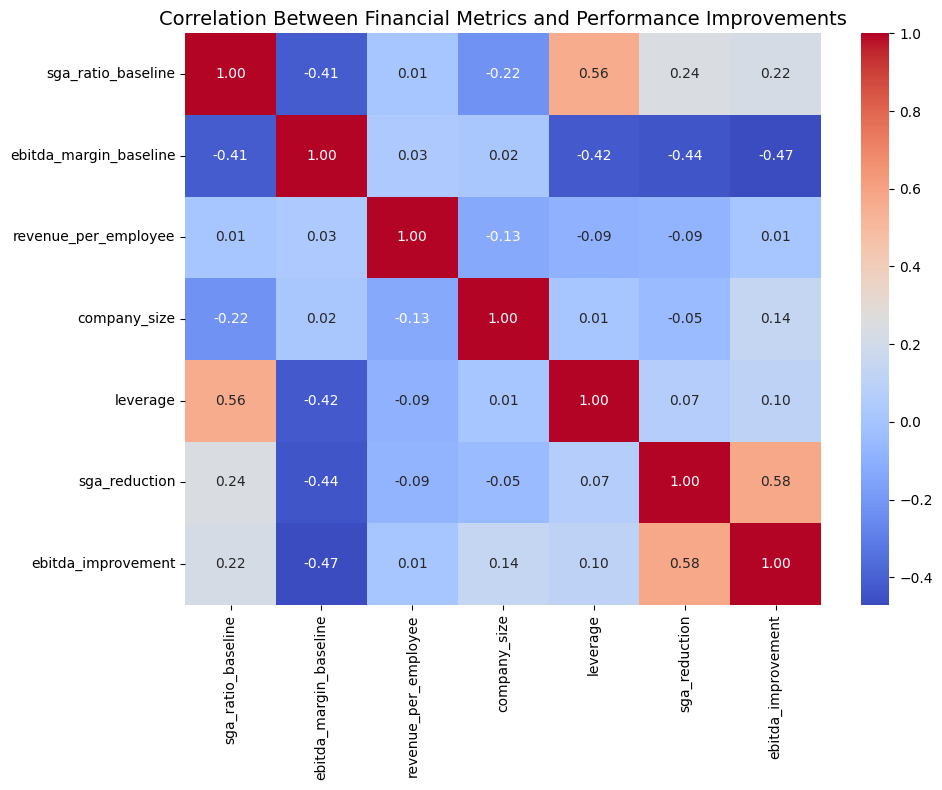

In [28]:
# Run multinomial logistic regression with statsmodels
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit

# Prepare features with controls (now that we added company_size and leverage)
X_with_controls = merged_df[['sga_ratio_baseline', 'ebitda_margin_baseline',
                             'revenue_per_employee', 'company_size', 'leverage']]
# Replace inf and NaN with 0 in X_with_controls
X_with_controls = X_with_controls.replace([np.inf, -np.inf], 0).fillna(0)
X_with_controls = sm.add_constant(X_with_controls)  # Add intercept

# Prepare categorical outcome
y_cat = merged_df['classification']

# Run multinomial logistic regression
model = MNLogit(y_cat, X_with_controls)
result = model.fit()

# Print summary
print(result.summary())

# Calculate odds ratios and confidence intervals
print("\nOdds Ratios:")
print(np.exp(result.params))
print("\n95% Confidence Intervals:")
print(np.exp(result.conf_int()))

# Calculate McFadden's R-squared
print(f"\nMcFadden's R-squared: {result.prsquared:.4f}")

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_metrics.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Between Financial Metrics and Performance Improvements', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

Result params structure:
                               0         1
const                  -3.519854 -0.653810
sga_ratio_baseline      4.884075 -0.620314
ebitda_margin_baseline -5.039567 -1.541293
revenue_per_employee    0.000142 -0.003210
company_size            0.237846  0.216611
leverage               -2.224964 -1.048951


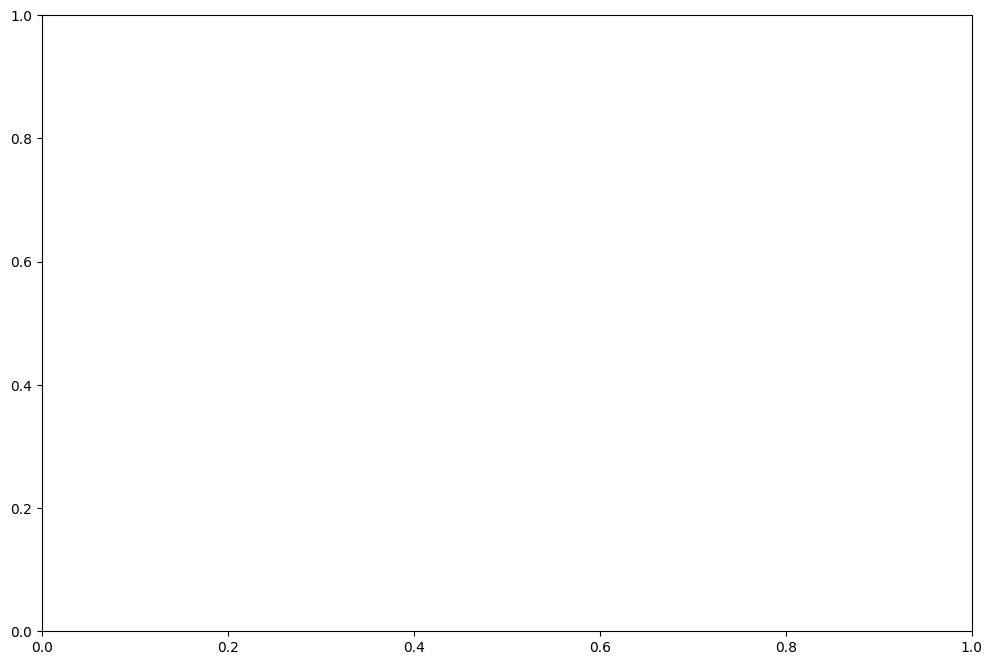

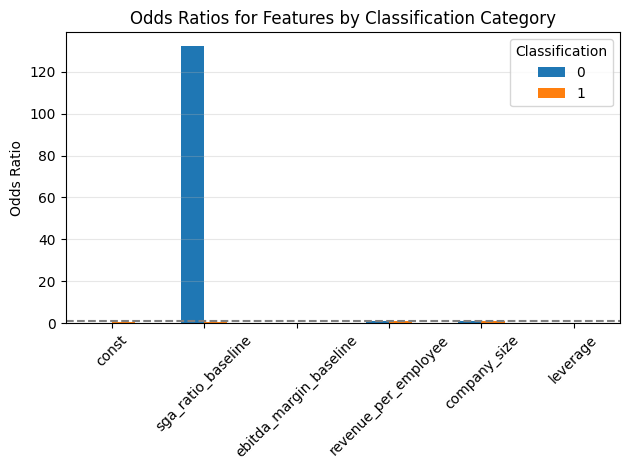

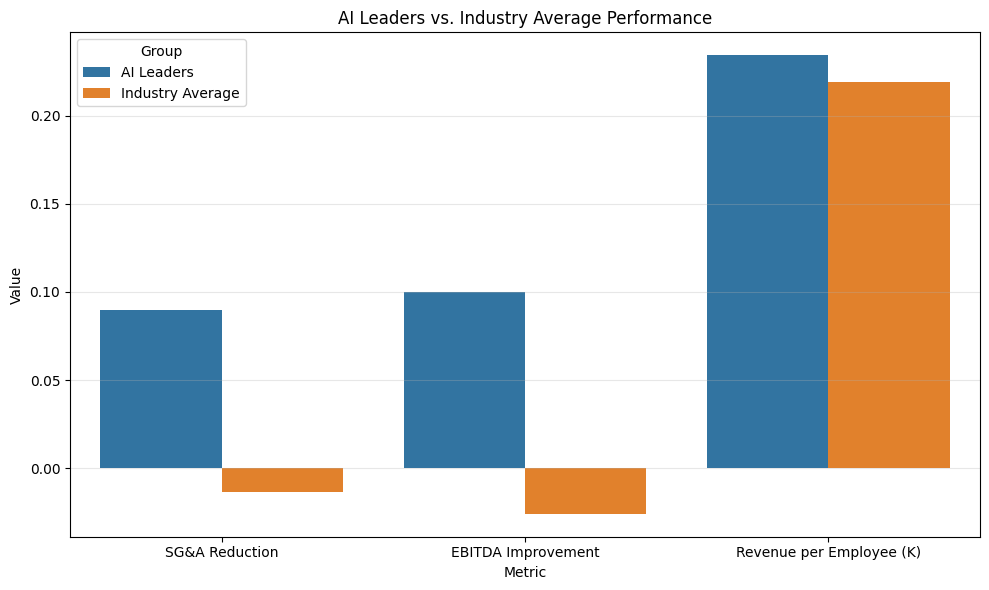

In [35]:
# Print the full structure of result.params
print("Result params structure:")
print(result.params)

# 2. ODDS RATIO VISUALIZATION - Fixed for actual structure
odds_ratios = np.exp(result.params)
plt.figure(figsize=(12, 8))

# Plot odds ratios - handle the actual structure with 2 columns
plt.subplot(1, 1, 1)
odds_ratios.plot(kind='bar')
plt.axhline(y=1, color='gray', linestyle='--')
plt.title('Odds Ratios for Features by Classification Category')
plt.ylabel('Odds Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Classification')
plt.tight_layout()
plt.savefig('odds_ratios.png', dpi=300)

# 3. PERFORMANCE COMPARISON CHART (unchanged - this should work)
performance_data = pd.DataFrame({
    'Metric': ['SG&A Reduction', 'EBITDA Improvement', 'Revenue per Employee (K)'],
    'AI Leaders': [
        merged_df[merged_df['classification'] == 'AI Leader']['sga_reduction'].mean(),
        merged_df[merged_df['classification'] == 'AI Leader']['ebitda_improvement'].mean(),
        merged_df[merged_df['classification'] == 'AI Leader']['revenue_per_employee'].mean() / 1000
    ],
    'Industry Average': [
        merged_df['sga_reduction'].mean(),
        merged_df['ebitda_improvement'].mean(),
        merged_df['revenue_per_employee'].mean() / 1000
    ]
})

# Create comparison plot
plt.figure(figsize=(10, 6))
performance_data_melted = pd.melt(performance_data, id_vars='Metric',
                                 var_name='Group', value_name='Value')
sns.barplot(data=performance_data_melted, x='Metric', y='Value', hue='Group')
plt.title('AI Leaders vs. Industry Average Performance')
plt.ylabel('Value')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('performance_comparison.png', dpi=300)

In [37]:
# Identify top companies in each category
# 1. Best opportunities (Turnaround Opportunities with highest potential)
best_opportunities = merged_df[merged_df['classification'] == 'Turnaround Opportunity'].sort_values(
    by=['company_size', 'sga_ratio_baseline'], ascending=[False, False]).head(5)

# 2. Worst opportunities (AI Laggards with worst metrics)
worst_opportunities = merged_df[merged_df['classification'] == 'AI Laggard'].sort_values(
    by=['sga_reduction', 'ebitda_improvement']).head(5)

# 3. Current winners (Top AI Leaders)
current_winners = merged_df[merged_df['classification'] == 'AI Leader'].sort_values(
    by=['ebitda_improvement', 'sga_reduction'], ascending=[False, False]).head(5)

# Print results with key metrics
print("TOP TURNAROUND OPPORTUNITIES (Largest companies with high SG&A ratios):")
for idx, row in best_opportunities.iterrows():
    print(f"{row['conm']} ({row['tic']}): SG&A Ratio: {row['sga_ratio_baseline']:.3f}, Size: {row['company_size']:.2f}")

print("\nWORST OPPORTUNITIES (AI Laggards with poorest performance):")
for idx, row in worst_opportunities.iterrows():
    print(f"{row['conm']} ({row['tic']}): SG&A Change: {row['sga_reduction']:.3f}, EBITDA Change: {row['ebitda_improvement']:.3f}")

print("\nTOP AI LEADERS (Best operational improvements):")
for idx, row in current_winners.iterrows():
    print(f"{row['conm']} ({row['tic']}): SG&A Change: {row['sga_reduction']:.3f}, EBITDA Change: {row['ebitda_improvement']:.3f}")

TOP TURNAROUND OPPORTUNITIES (Largest companies with high SG&A ratios):
WESTON (GEORGE) LTD (WNGRF): SG&A Ratio: 0.237, Size: 10.53
MCDONALD'S CORP (MCD): SG&A Ratio: 0.094, Size: 10.45
LOBLAW COS LTD (LBLCF): SG&A Ratio: 0.224, Size: 10.43
COSTCO WHOLESALE CORP (COST): SG&A Ratio: 0.100, Size: 10.41
KONINKLIJKE AHOLD DELHAIZE (ADRNY): SG&A Ratio: 0.231, Size: 10.09

WORST OPPORTUNITIES (AI Laggards with poorest performance):
FRESHII INC (FRHHF): SG&A Change: -0.354, EBITDA Change: -0.393
WENDY'S CO (WEN): SG&A Change: -0.269, EBITDA Change: -0.013
AEGIS BRANDS INC (SCUPF): SG&A Change: -0.214, EBITDA Change: -0.152
WINGSTOP INC (WING): SG&A Change: -0.191, EBITDA Change: -0.078
RESTAURANT BRANDS INTL LP (RSTRF): SG&A Change: -0.146, EBITDA Change: -0.151

TOP AI LEADERS (Best operational improvements):
HEALTHIER CHOICES MNGMT CORP (HCMC): SG&A Change: 0.376, EBITDA Change: 0.525
ONE GP HOSPITALITY (THE) (STKS): SG&A Change: 0.159, EBITDA Change: 0.116
DOLLARAMA INC (DLMAF): SG&A Chang

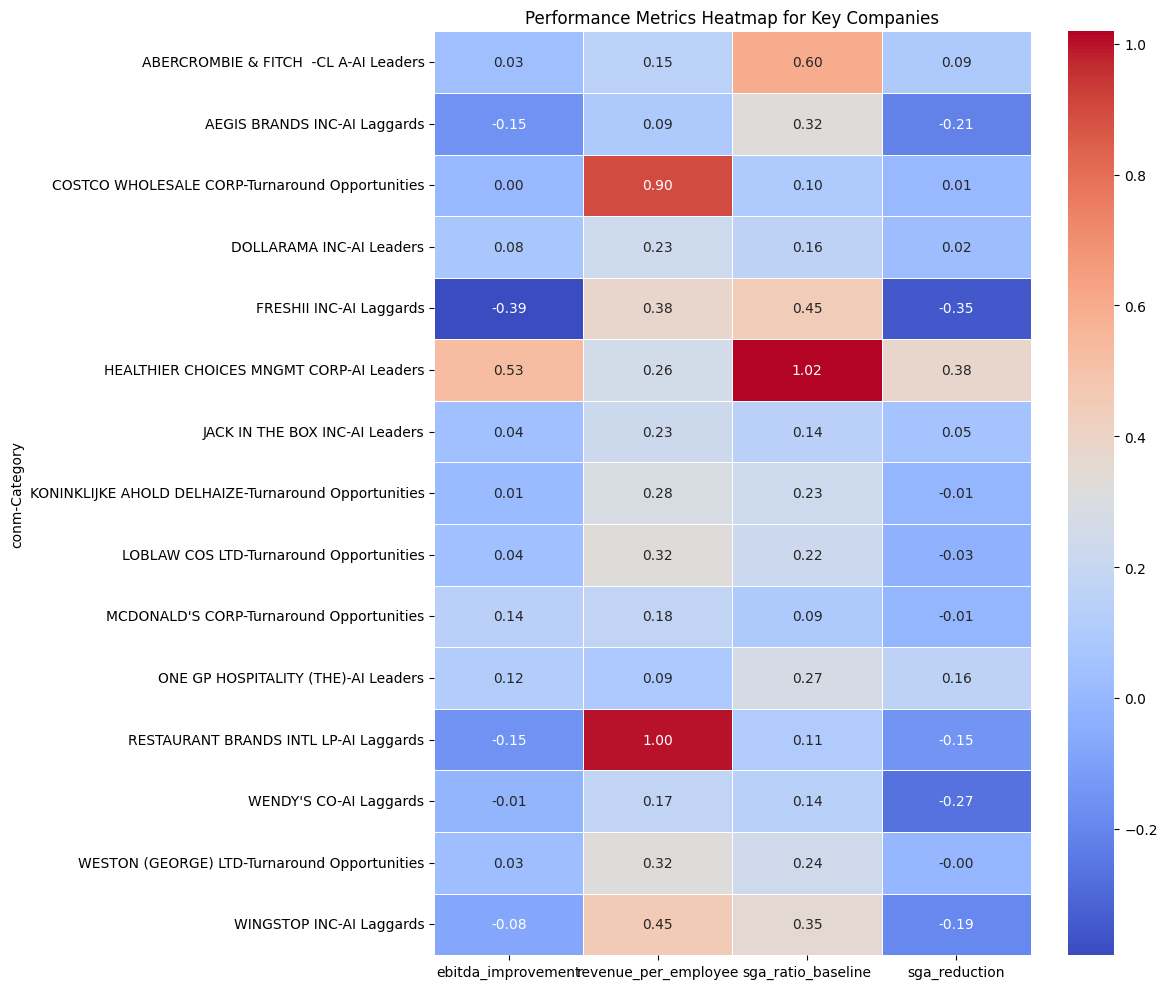

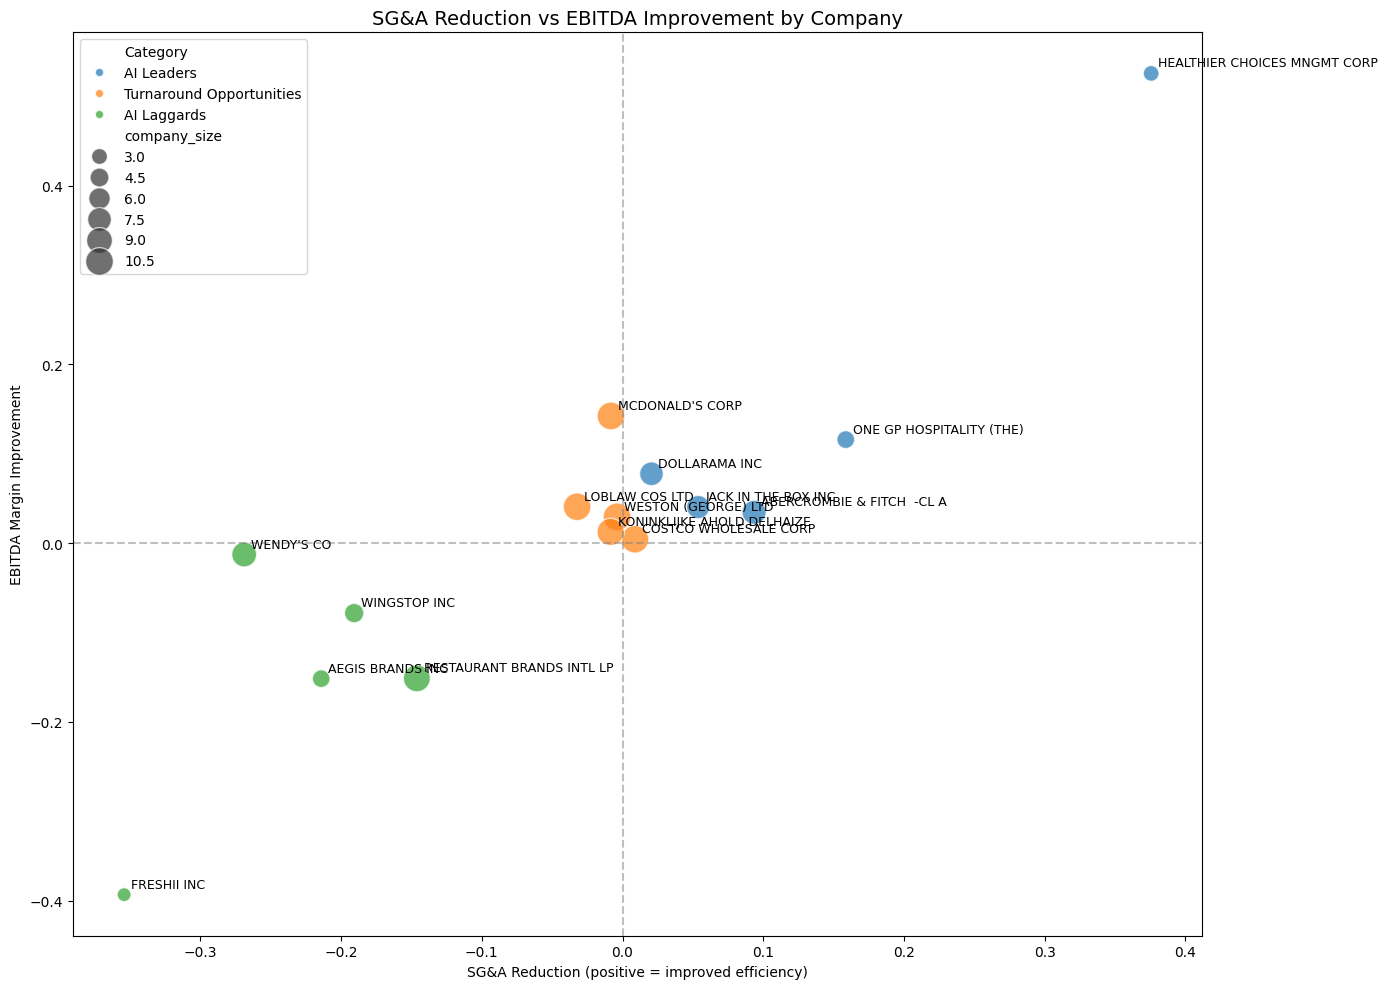

In [39]:
# Select top companies from each category
best_opportunities = merged_df[merged_df['classification'] == 'Turnaround Opportunity'].sort_values(
    by=['company_size', 'sga_ratio_baseline'], ascending=[False, False]).head(5)

worst_opportunities = merged_df[merged_df['classification'] == 'AI Laggard'].sort_values(
    by=['sga_reduction', 'ebitda_improvement']).head(5)

current_winners = merged_df[merged_df['classification'] == 'AI Leader'].sort_values(
    by=['ebitda_improvement', 'sga_reduction'], ascending=[False, False]).head(5)

# Combine for visualization
top_companies = pd.concat([
    current_winners.assign(Category='AI Leaders'),
    best_opportunities.assign(Category='Turnaround Opportunities'),
    worst_opportunities.assign(Category='AI Laggards')
])

# Create heatmap data
heatmap_metrics = ['sga_reduction', 'ebitda_improvement', 'revenue_per_employee', 'sga_ratio_baseline']
heatmap_data = top_companies.pivot_table(
    index=['conm', 'Category'],
    values=heatmap_metrics
)

# Scale the revenue_per_employee column to make it comparable
heatmap_data['revenue_per_employee'] = heatmap_data['revenue_per_employee'] / heatmap_data['revenue_per_employee'].max()

# Heatmap visualization
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Performance Metrics Heatmap for Key Companies')
plt.tight_layout()
plt.savefig('company_heatmap.png', dpi=300)

# Scatter plot with annotations
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=top_companies,
    x='sga_reduction',
    y='ebitda_improvement',
    hue='Category',
    size='company_size',
    sizes=(100, 400),
    alpha=0.7
)

# Add company names as annotations
for idx, row in top_companies.iterrows():
    plt.annotate(
        row['conm'],
        xy=(row['sga_reduction'], row['ebitda_improvement']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.title('SG&A Reduction vs EBITDA Improvement by Company', fontsize=14)
plt.xlabel('SG&A Reduction (positive = improved efficiency)')
plt.ylabel('EBITDA Margin Improvement')
plt.tight_layout()
plt.savefig('company_performance_scatter.png', dpi=300)